In [1]:
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

In [3]:
 role = get_execution_role()
# prefix = 'sagemaker/DEMO-xgboost-dm'
# my_region = boto3.session.Session().region_name # set the region of the instance

# # this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")

# print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + xgboost_container + " container for your SageMaker endpoint.")

In [4]:
# bucket = 'vengalarao' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
# my_region = boto3.session.Session().region_name # set the region of the instance
# print(my_region)

In [5]:
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': 'us-west-2' })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 error:  name 'my_region' is not defined


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [6]:
bucket_name = 'lava-proj' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': 'us-west-2' })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 error:  name 'my_region' is not defined


In [7]:
prefix = 'xgboost-as-a-built-in-algo'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://lava-proj/xgboost-as-a-built-in-algo/output


In [8]:
import pandas as pd
import urllib
# try:
#     urllib.request.urlretrieve ("https://d1.awsstatic.com/tmt/build-train-deploy-machine-learning-model-sagemaker/bank_clean.27f01fbbdf43271788427f3682996ae29ceca05d.csv", "bank_clean.csv")
#     print('Success: downloaded bank_clean.csv.')
# except Exception as e:
#     print('Data load error: ',e)

try:
    data = pd.read_csv('train-1.csv')
    data2 = pd.read_csv('test-2.csv')
    print('Success: Data loaded into dataframe.')
    data.head()
except Exception as e:
    print('Data load error: ',e)
    
# try:
#     data2 = pd.read_csv('test-2.csv',index_col=0)
#     print('Success: Data2 loaded into dataframe.')
#     data2.head()
# except Exception as e:
#     print('Data load error: ',e)

Success: Data loaded into dataframe.


In [9]:
new_df=pd.concat([data,data2])

In [10]:
new_df.shape

(2919, 81)

In [11]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [12]:
new_df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
                 ... 
MoSold              0
YrSold              0
SaleType            1
SaleCondition       0
SalePrice        1459
Length: 81, dtype: int64

In [13]:
df=new_df

In [14]:
df['LotFrontage']=df['LotFrontage'].fillna(df['LotFrontage'].mean())
df.drop(['Alley'],axis=1,inplace=True)
df['BsmtCond']=df['BsmtCond'].fillna(df['BsmtCond'].mode()[0])
df['BsmtQual']=df['BsmtQual'].fillna(df['BsmtQual'].mode()[0])
df['FireplaceQu']=df['FireplaceQu'].fillna(df['FireplaceQu'].mode()[0])
df['GarageType']=df['GarageType'].fillna(df['GarageType'].mode()[0])
df.drop(['GarageYrBlt'],axis=1,inplace=True)
df['GarageFinish']=df['GarageFinish'].fillna(df['GarageFinish'].mode()[0])
df['GarageQual']=df['GarageQual'].fillna(df['GarageQual'].mode()[0])
df['GarageCond']=df['GarageCond'].fillna(df['GarageCond'].mode()[0])
df.drop(['PoolQC','Fence','MiscFeature'],axis=1,inplace=True)
df.drop(['Id'],axis=1,inplace=True)
df['MasVnrType']=df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])
df['MasVnrArea']=df['MasVnrArea'].fillna(df['MasVnrArea'].mode()[0])
df['BsmtExposure']=df['BsmtExposure'].fillna(df['BsmtExposure'].mode()[0])
df['BsmtFinType2']=df['BsmtFinType2'].fillna(df['BsmtFinType2'].mode()[0])
df.dropna(inplace=True)

<AxesSubplot:>

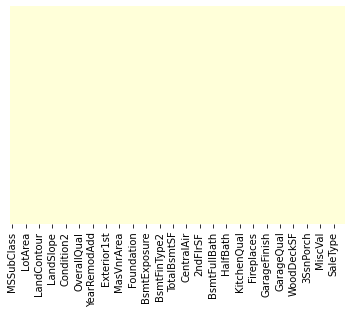

In [15]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='YlGnBu')

### convert catgorical to numatical data

In [16]:
from sklearn.preprocessing import label_binarize,LabelEncoder

In [17]:
cat_bf=df.select_dtypes(exclude=np.number)
cat_bf.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [18]:
lb=LabelEncoder()
for i in cat_bf.columns:
    df[i]=lb.fit_transform(np.array(df[i]).reshape(-1,1))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [19]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.0,8450,1,3,3,0,4,0,...,0,0,0,0,0,2,2008,8,4,208500.0
1,20,3,80.0,9600,1,3,3,0,2,0,...,0,0,0,0,0,5,2007,8,4,181500.0
2,60,3,68.0,11250,1,0,3,0,4,0,...,0,0,0,0,0,9,2008,8,4,223500.0
3,70,3,60.0,9550,1,0,3,0,0,0,...,272,0,0,0,0,2,2006,8,0,140000.0
4,60,3,84.0,14260,1,0,3,0,2,0,...,0,0,0,0,0,12,2008,8,4,250000.0


### take test data

In [20]:
import os
from sklearn.model_selection import train_test_split

In [21]:
train_data, validation_data, test_data = np.split(
    df.sample(frac=1, random_state=1729),
    [int(0.7 * len(df)), int(0.9 * len(df))],
)
train_data.to_csv("train.csv", header=False, index=False)
validation_data.to_csv("validation.csv", header=False, index=False)

#### upload data

In [22]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [23]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation'.format(bucket_name, prefix), content_type='csv')

In [24]:
pd.concat([train_data['SalePrice'], train_data.drop(['SalePrice'], 
                                                axis=1)], 
                                                axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')


In [25]:
pd.concat([test_data['SalePrice'], test_data.drop(['SalePrice'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
s3_input_test = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')

In [26]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.0,8450,1,3,3,0,4,0,...,0,0,0,0,0,2,2008,8,4,208500.0
1,20,3,80.0,9600,1,3,3,0,2,0,...,0,0,0,0,0,5,2007,8,4,181500.0
2,60,3,68.0,11250,1,0,3,0,4,0,...,0,0,0,0,0,9,2008,8,4,223500.0
3,70,3,60.0,9550,1,0,3,0,0,0,...,272,0,0,0,0,2,2006,8,0,140000.0
4,60,3,84.0,14260,1,0,3,0,2,0,...,0,0,0,0,0,12,2008,8,4,250000.0


In [27]:
df_Train=df.iloc[:1422,:]
df_Test=df.iloc[1422:,:]

In [28]:
df_Test.drop(['SalePrice'],axis=1,inplace=True)
X_train=df_Train.drop(['SalePrice'],axis=1)
y_train=df_Train['SalePrice']

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [29]:
container = get_image_uri(boto3.Session().region_name,
                          'xgboost', 
                          repo_version='1.0-1')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [30]:
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"binary:logistic",
 

       "num_round":50
        }

In [31]:
estimator = sagemaker.estimator.Estimator(image_uri=container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          train_instance_count=1, 
                                          train_instance_type='ml.m5.2xlarge', 
                                          train_volume_size=5, # 5 GB 
                                          output_path=output_path,
                                          train_use_spot_instances=True,
                                          train_max_run=300,
                                          train_max_wait=600)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_use_spot_instances has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_wait has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [32]:
estimator.fit({'train': s3_input_train,'validation': s3_input_test})

2022-05-14 07:51:43 Starting - Starting the training job...
2022-05-14 07:51:45 Starting - Launching requested ML instancesProfilerReport-1652514702: InProgress
......
2022-05-14 07:53:12 Starting - Preparing the instances for training......
2022-05-14 07:54:08 Downloading - Downloading input data
2022-05-14 07:54:08 Training - Downloading the training image...
2022-05-14 07:54:44 Uploading - Uploading generated training modelINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[07:54:24] 995x74 matrix with 73630 entries loaded 

UnexpectedStatusException: Error for Training job sagemaker-xgboost-2022-05-14-07-51-42-899: Failed. Reason: AlgorithmError: framework error: 
Traceback (most recent call last):
  File "/miniconda3/lib/python3.6/site-packages/sagemaker_xgboost_container/algorithm_mode/train.py", line 226, in train_job
    verbose_eval=False)
  File "/miniconda3/lib/python3.6/site-packages/xgboost/training.py", line 209, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/miniconda3/lib/python3.6/site-packages/xgboost/training.py", line 74, in _train_internal
    bst.update(dtrain, i, obj)
  File "/miniconda3/lib/python3.6/site-packages/xgboost/core.py", line 1248, in update
    dtrain.handle))
  File "/miniconda3/lib/python3.6/site-packages/xgboost/core.py", line 189, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [07:54:24] /workspace/src/objective/regression_obj.cu:102: label must be in [0,1] for logistic regression
Stack trace:
  [bt] (0) /miniconda3/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x54) [0x7f39a1168614]

In [36]:
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(container,role, instance_count=1, instance_type='ml.m4.xlarge',output_path='s3://{}/{}/output'.format(bucket_name, prefix),sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,subsample=0.8,silent=0,objective='binary:logistic',num_round=100)


In [ ]:
xgb.fit({'train': s3_input_train,'validation': s3_input_test})

2022-05-14 08:00:36 Starting - Starting the training job...
2022-05-14 08:01:02 Starting - Preparing the instances for trainingProfilerReport-1652515236: InProgress
.........
2022-05-14 08:02:34 Downloading - Downloading input data......
2022-05-14 08:03:20 Training - Downloading the training image...
2022-05-14 08:04:05 Training - Training image download completed. Training in progress...INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[08:04:09] 995x74 matrix with 73630 entries loaded from /opt/ml/input/data/train?format=c